### Workflow For the project

Step 1 - Download the data from kaggle- https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh
         and import the data

Step 2 - EDA (Exploratory Data Analysis)

Step 3 - Preprocessing the data (Converting the data into numeric form and filling the missing values)

Step 4 - Fit a Machine Learning model and Evaluate the model on the data

Step 5 - Improving the model (hyperparameter tuning,cross-validation)

Step 6 - Evaluating and saving final model

In [1]:
# importing libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV

## EDA

let's analyse our data and try to find some relation between the features and the label

In [3]:
# importing our data
data = pd.read_excel('C:\\Users\\Aditya\\Desktop\\python3\\data\\Data_Train.xlsx')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


So here we can see that the `Price` column is our label and all the other columns are our features 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


**NOTE**-
As we can see that all the features are of object datatype but we don't want the `Date_of_Journey`, `Dep_Time`, `Arrival_Time` to be object, instead we want to convert them into 'DATETIME' and extract the months, days, hours and minutes from them and create new features like `Month_of_Journey`, `Day_of_Journey`,etc.

In [7]:
# Creating a function to convert those columns into datetime dtype
def To_Datetime(column):
    data[column] = pd.to_datetime(data[column])
    return data[column]

In [8]:
# convert the columns we want into datetime
To_Datetime('Date_of_Journey')
To_Datetime('Dep_Time')
To_Datetime('Arrival_Time')

0       2021-03-22 01:10:00
1       2021-09-06 13:15:00
2       2021-06-10 04:25:00
3       2021-09-06 23:30:00
4       2021-09-06 21:35:00
                ...        
10678   2021-09-06 22:25:00
10679   2021-09-06 23:20:00
10680   2021-09-06 11:20:00
10681   2021-09-06 14:10:00
10682   2021-09-06 19:15:00
Name: Arrival_Time, Length: 10683, dtype: datetime64[ns]

Now that we have converted those columns into datetime we need to extract the day,hours and minutes from those columns


In [11]:
# creating new columns
data['Day_of_Journey'] = data['Date_of_Journey'].dt.day
data['Month_of_Journey'] = data['Date_of_Journey'].dt.month

data['Dep_hour'] = data['Dep_Time'].dt.hour
data['Dep_minute'] = data['Dep_Time'].dt.minute

data['Arrival_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_minute'] = data['Arrival_Time'].dt.minute

data.drop('Date_of_Journey',axis=1,inplace=True)
data.drop('Dep_Time',axis=1,inplace=True)
data.drop('Arrival_Time',axis=1,inplace=True)

For the `Duration` column we will convert the hours into minutes and add to the existing minutes
so for eg: 1hr 10 mins will become 70 

In [14]:
# converting duration into minutes
data['Duration'] = data['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [16]:
# let's take a look at our data now
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Airline           10683 non-null  object
 1   Source            10683 non-null  object
 2   Destination       10683 non-null  object
 3   Route             10682 non-null  object
 4   Duration          10683 non-null  int64 
 5   Total_Stops       10682 non-null  object
 6   Additional_Info   10683 non-null  object
 7   Price             10683 non-null  int64 
 8   Day_of_Journey    10683 non-null  int64 
 9   Month_of_Journey  10683 non-null  int64 
 10  Dep_hour          10683 non-null  int64 
 11  Dep_minute        10683 non-null  int64 
 12  Arrival_hour      10683 non-null  int64 
 13  Arrival_minute    10683 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 1.1+ MB


All right we have now extracted all the information from the datetime columns

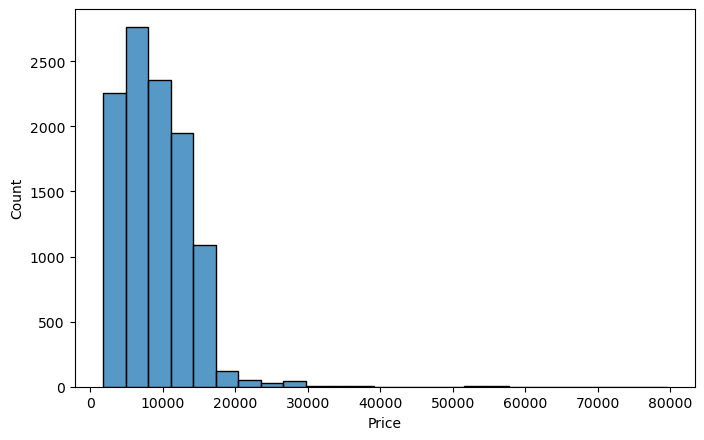

In [9]:
# visualizing the distribution of Price column
plt.figure(figsize=(8,5),dpi=100)
sns.histplot(data=data,x='Price',bins=25);

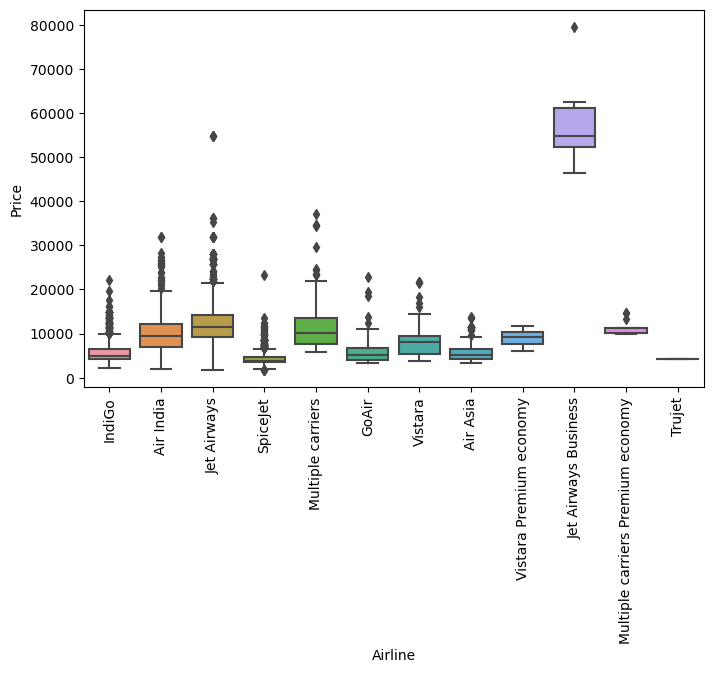

In [58]:
# let's try to visualize our data by comparing price and airline columns first
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Airline',y='Price',data=data)
plt.xticks(rotation=90);

we can see that jet airways business airline has the highest prices out of all and it's also quite obvious because 
business class fares are higher than economy class

In [29]:
data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

even though the price of jet airways business is the highest of all 
but we can see here that there are only 6 of those flights 

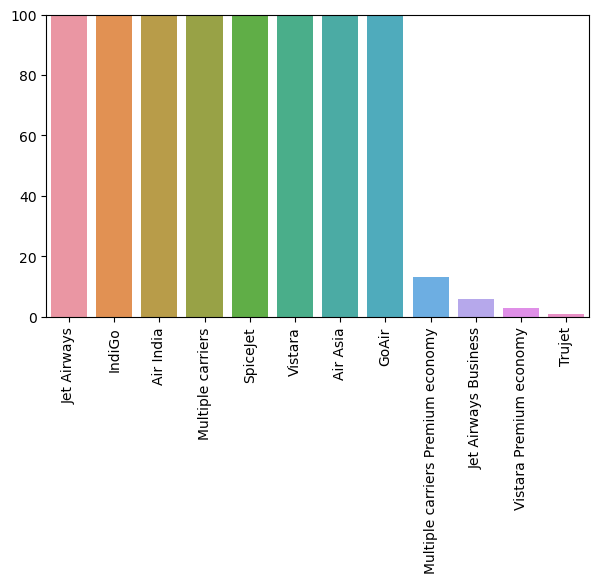

In [28]:
# let's visualize the count of each airline
plt.figure(figsize=(7,4),dpi=100)
sns.barplot(x=data['Airline'].value_counts().index,y=data['Airline'].value_counts().values)
plt.xticks(rotation=90)
plt.ylim(0,100);

In [30]:
data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
Red-eye flight                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

only 4 business class flights and these are probably the ones with the highest prices
and also the 'No Info' and the 'No info' classes are the same so we can just merge them into one

In [31]:
data[data['Additional_Info']=='No Info']

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
795,IndiGo,Banglore,New Delhi,BLR → HYD → DEL,295,1 stop,No Info,8153,3,1,16,55,21,50
2212,IndiGo,Banglore,New Delhi,BLR → HYD → DEL,260,1 stop,No Info,7917,3,1,16,15,20,35
9220,IndiGo,Banglore,New Delhi,BLR → HYD → DEL,285,1 stop,No Info,8064,3,1,5,15,10,0


In [33]:
data.at[[795,2212,9220],'Additional_Info'] = 'No info'

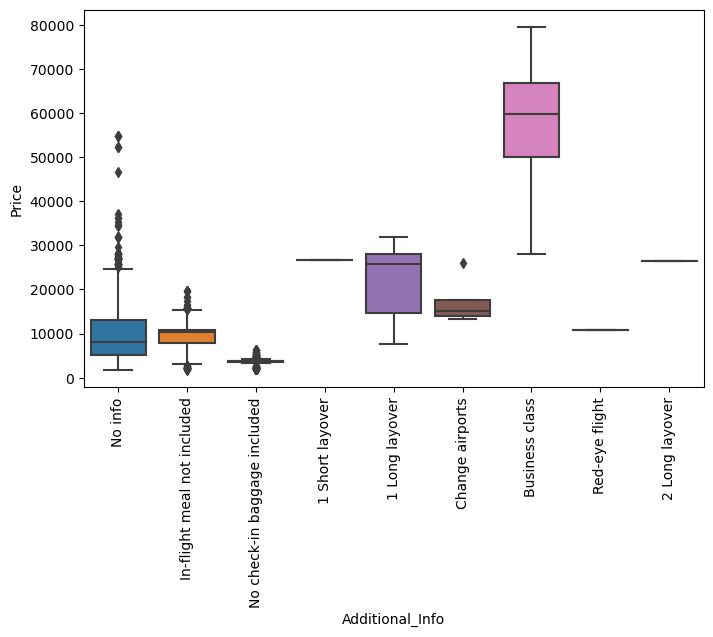

In [65]:
# LET'S visualize additional_info column
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Additional_Info',y='Price',data=data)
plt.xticks(rotation=90);

The 3 flights with prices higher than 40000 and additional_Info as 'No info' can also be business class flights

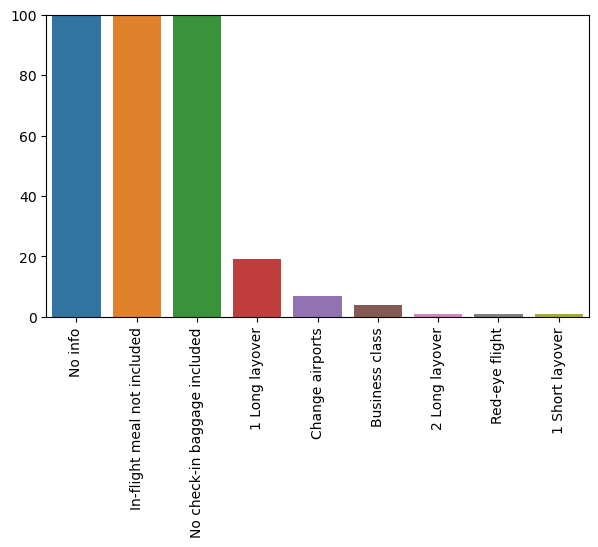

In [57]:
plt.figure(figsize=(7,4),dpi=100)
sns.barplot(x=data['Additional_Info'].value_counts().index,y=data['Additional_Info'].value_counts().values)
plt.xticks(rotation=90)
plt.ylim(0,100);

Also there are very less number of 2 long layover , red-eye and 1 short layover flights

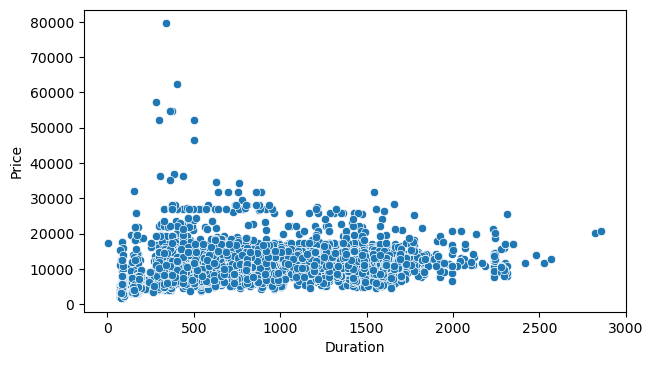

In [36]:
# let's visualize the duration and price relationship
plt.figure(figsize=(7,4),dpi=100)
sns.scatterplot(x='Duration',y='Price',data=data);

for majority of the airlines the price is same as per the duration 
the flights with high prices we are seeing here are probably the business class and premium economy class airlines

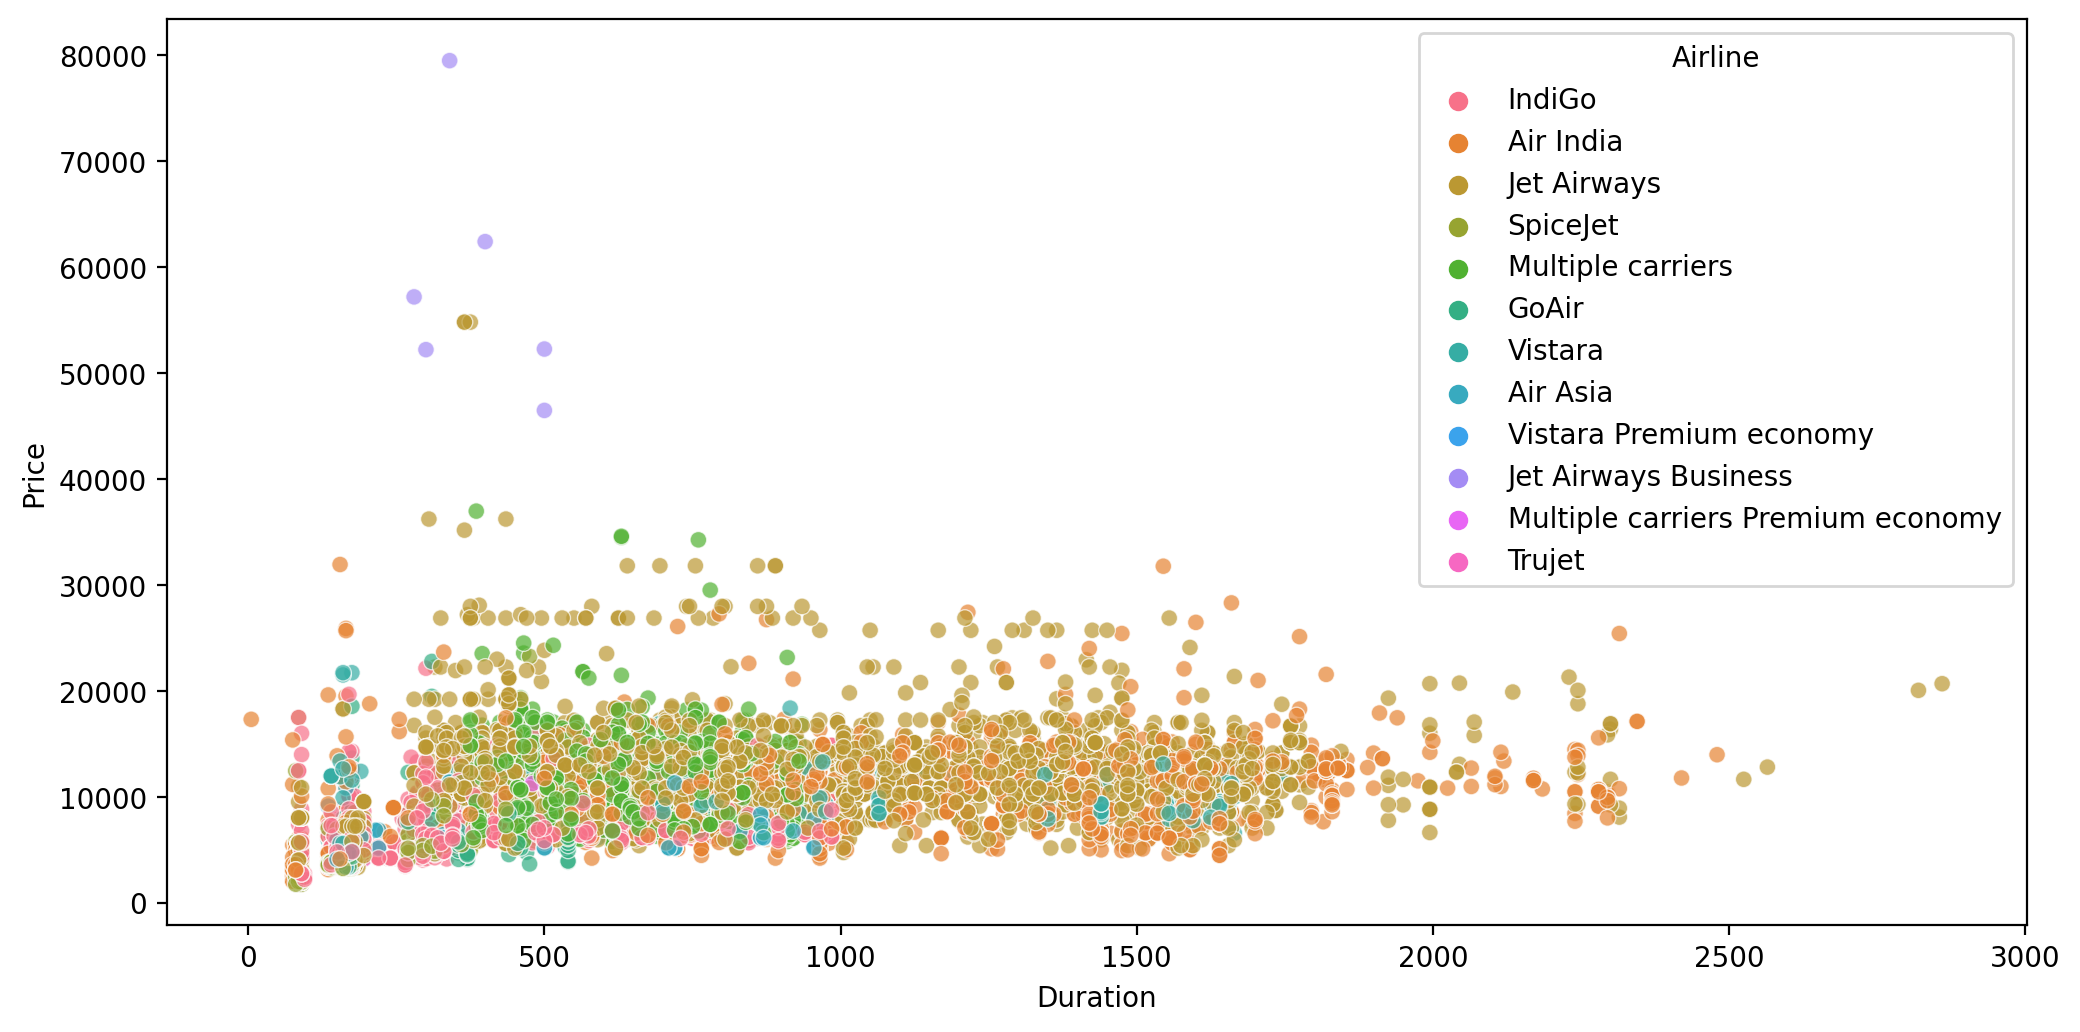

In [44]:
plt.figure(figsize=(12,6),dpi=200)
sns.scatterplot(x='Duration',y='Price',data=data,hue='Airline',alpha=0.7,legend='brief');

In [50]:
data[data['Price']>70000]

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
2924,Jet Airways Business,Banglore,New Delhi,BLR → BOM → DEL,340,1 stop,Business class,79512,3,1,5,45,11,25


In [46]:
data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

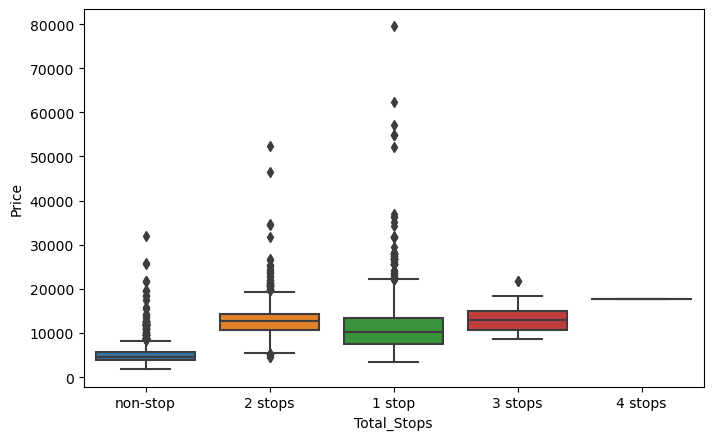

In [55]:
# visualizing total_stops and price
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Total_Stops',y='Price',data=data);

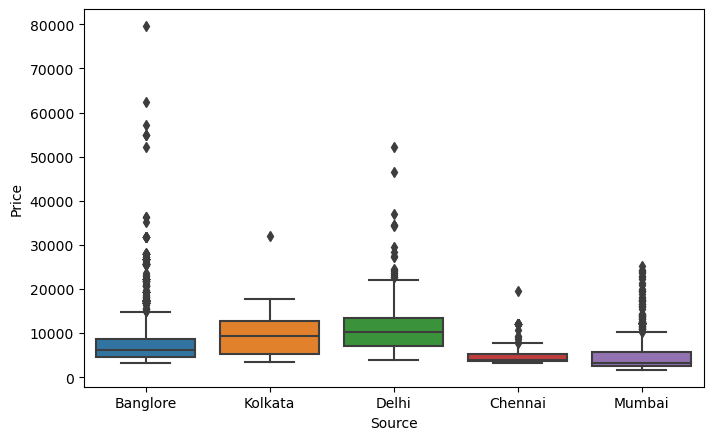

In [59]:
# lastly we will see the source and destination's relation with price
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Source',y='Price',data=data);

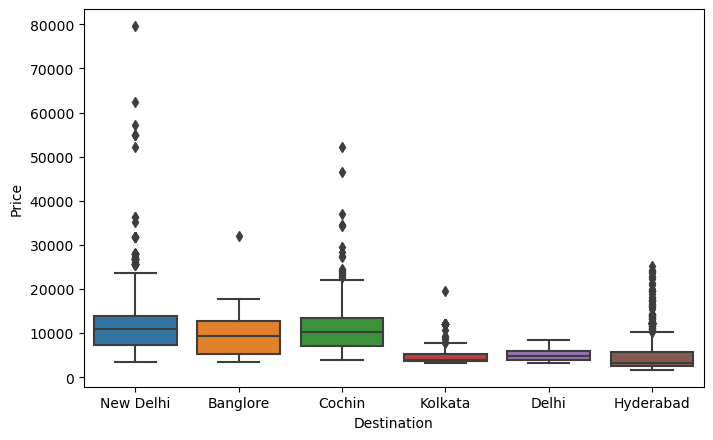

In [60]:
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Destination',y='Price',data=data);

here New Delhi and Delhi can be the same so we will merge them 

In [63]:
data['Destination'].replace('New Delhi','Delhi',inplace=True)

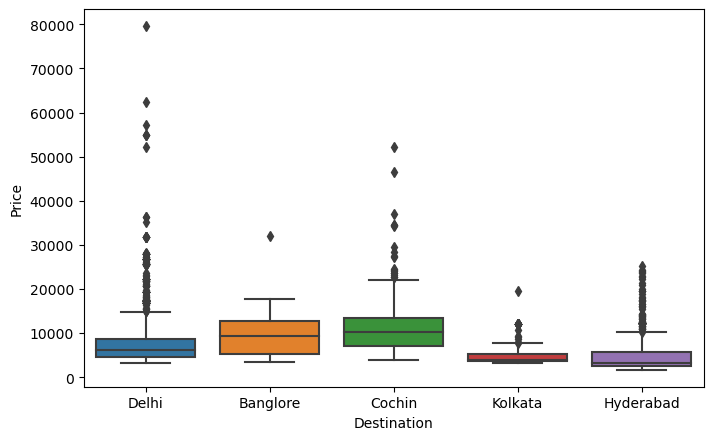

In [64]:
# visualize again
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(x='Destination',y='Price',data=data);

**By analysing the data I've come to know that the price of the flight depends heavily on the The class(business,economy),
the airline type and the total number of stops. Also more the number of stopovers the longer the duration of the flight** 

## Data Cleaning/Preprocessing

Two things to do here 
* taking care of missing values
* encoding categorical features

In [66]:
# let's take a look at our data
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35


In [68]:
# let's see missing values
data.isna().sum()

Airline             0
Source              0
Destination         0
Route               1
Duration            0
Total_Stops         1
Additional_Info     0
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_hour            0
Dep_minute          0
Arrival_hour        0
Arrival_minute      0
dtype: int64

our data is pretty much cleaned already. We have only 2 missing values. Let's take a look at those rows

In [69]:
data[data['Route'].isna()]

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
9039,Air India,Delhi,Cochin,NaN,1420,NaN,No info,7480,5,6,9,45,9,25


luckily those 2 values belong to a single row so we can just drop that row

In [70]:
data = data.dropna()

In [75]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,10682.0,643.020502,507.830133,5.0,170.0,520.0,930.0,2860.0
Price,10682.0,9087.214567,4611.548810,1759.0,5277.0,8372.0,12373.0,79512.0
Day_of_Journey,10682.0,12.682925,8.803800,3.0,5.0,6.0,21.0,27.0
Month_of_Journey,10682.0,5.534731,2.987626,1.0,3.0,5.0,6.0,12.0
Dep_hour,10682.0,12.491013,5.748820,0.0,8.0,11.0,18.0,23.0
Dep_minute,10682.0,24.409287,18.767801,0.0,5.0,25.0,40.0,55.0
Arrival_hour,10682.0,13.349186,6.859317,0.0,8.0,14.0,19.0,23.0
Arrival_minute,10682.0,24.690601,16.506808,0.0,10.0,25.0,35.0,55.0


If we observe the duration row we can see that the minimum value for duration is only 5 mins
but it's impossible for any flight to have a min duration of 5 mins 
so there might've been some kind of mistake while creating this record,  
now we can find some value to replace this or we can just drop this row

In [76]:
data[data['Duration']==5]

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
6474,Air India,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,5,2 stops,No info,17327,3,6,16,50,16,55


In [77]:
# drop this row 
data = data.drop(index=6474,axis=0)

In [78]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,10681.0,643.080236,507.816377,75.0,170.0,520.0,930.0,2860.0
Price,10681.0,9086.443123,4611.075357,1759.0,5277.0,8372.0,12373.0,79512.0
Day_of_Journey,10681.0,12.683831,8.803713,3.0,5.0,6.0,21.0,27.0
Month_of_Journey,10681.0,5.534688,2.987762,1.0,3.0,5.0,6.0,12.0
Dep_hour,10681.0,12.490684,5.748989,0.0,8.0,11.0,18.0,23.0
Dep_minute,10681.0,24.406891,18.767046,0.0,5.0,25.0,40.0,55.0
Arrival_hour,10681.0,13.348937,6.859590,0.0,8.0,14.0,19.0,23.0
Arrival_minute,10681.0,24.687763,16.504975,0.0,10.0,25.0,35.0,55.0


everything is looking good now. let's move to encoding the categorical features

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10681 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Airline           10681 non-null  object
 1   Source            10681 non-null  object
 2   Destination       10681 non-null  object
 3   Route             10681 non-null  object
 4   Duration          10681 non-null  int64 
 5   Total_Stops       10681 non-null  object
 6   Additional_Info   10681 non-null  object
 7   Price             10681 non-null  int64 
 8   Day_of_Journey    10681 non-null  int64 
 9   Month_of_Journey  10681 non-null  int64 
 10  Dep_hour          10681 non-null  int64 
 11  Dep_minute        10681 non-null  int64 
 12  Arrival_hour      10681 non-null  int64 
 13  Arrival_minute    10681 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 1.2+ MB


we need to encode the `Airline`,`Source`,`Destination`,`Total_Stops`,`Additional_Info`,`Route`

before doing that we will make a copy of our dataset

In [104]:
# making a copy of our data
data_copy = data.copy()

In [105]:
data_copy.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35


In [106]:
# encoding Total_Stops

total_dict = {'non-stop':0,
              '1 stop':1,
              '2 stops':2,
              '3 stops':3,
              '4 stops':4}

data_copy['Total_Stops'] = data_copy['Total_Stops'].map(total_dict)
data_copy.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,Delhi,BLR → DEL,170,0,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,285,1,No info,13302,3,1,16,50,21,35


In [107]:
data_copy['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [108]:
data_copy['Route'].value_counts()

DEL → BOM → COK                2376
BLR → DEL                      1552
CCU → BOM → BLR                 979
CCU → BLR                       724
BOM → HYD                       621
                               ... 
BLR → HBX → BOM → BHO → DEL       1
BOM → BBI → HYD                   1
CCU → VTZ → BLR                   1
BOM → JLR → HYD                   1
BOM → GOI → HYD                   1
Name: Route, Length: 128, dtype: int64

for encoding the `Route` column we need to separate the routes and then encode them one by one

In [109]:
# encoding the route column

data_copy['Route_A'] = data_copy['Route'].str.split('→').str[0]
data_copy['Route_B'] = data_copy['Route'].str.split('→').str[1]
data_copy['Route_C'] = data_copy['Route'].str.split('→').str[2]
data_copy['Route_D'] = data_copy['Route'].str.split('→').str[3]
data_copy['Route_E'] = data_copy['Route'].str.split('→').str[4]

In [110]:
data_copy.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Route_A,Route_B,Route_C,Route_D,Route_E
0,IndiGo,Banglore,Delhi,BLR → DEL,170,0,No info,3897,24,3,22,20,1,10,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2,No info,7662,5,1,5,50,13,15,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2,No info,13882,6,9,9,25,4,25,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1,No info,6218,5,12,18,5,23,30,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,285,1,No info,13302,3,1,16,50,21,35,BLR,NAG,DEL,NaN,NaN


In [111]:
# filling the missing values
for i in ['Route_A','Route_B','Route_C','Route_D','Route_E']:
    data_copy[i] = data_copy[i].fillna('None')

In [112]:
data_copy.isna().sum()

Airline             0
Source              0
Destination         0
Route               0
Duration            0
Total_Stops         0
Additional_Info     0
Price               0
Day_of_Journey      0
Month_of_Journey    0
Dep_hour            0
Dep_minute          0
Arrival_hour        0
Arrival_minute      0
Route_A             0
Route_B             0
Route_C             0
Route_D             0
Route_E             0
dtype: int64

In [113]:
# encoding the routes

le = LabelEncoder()

for i in ['Route_A','Route_B','Route_C','Route_D','Route_E']:
    data_copy[i] = le.fit_transform(data_copy[i])

In [115]:
# we will also encode the Airline column using labelencoder
data_copy['Airline'] = le.fit_transform(data_copy['Airline'])

In [118]:
# we can drop the original route column
data_copy.drop('Route',axis=1,inplace=True)
data_copy.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Route_A,Route_B,Route_C,Route_D,Route_E
0,3,Banglore,Delhi,170,0,No info,3897,24,3,22,20,1,10,0,13,29,13,5
1,1,Kolkata,Banglore,445,2,No info,7662,5,1,5,50,13,15,2,25,1,3,5
2,4,Delhi,Cochin,1140,2,No info,13882,6,9,9,25,4,25,3,32,4,5,5
3,3,Kolkata,Banglore,325,1,No info,6218,5,12,18,5,23,30,2,34,3,13,5
4,3,Banglore,Delhi,285,1,No info,13302,3,1,16,50,21,35,0,34,8,13,5


Now only 3 columns are remaining to encode. We will use OneHotEncoding for those columns

In [119]:
object_df = data_copy.select_dtypes(include='object')
numeric_df = data_copy.select_dtypes(exclude='object')

In [122]:
# encoding object_df

object_df_dummies = pd.get_dummies(object_df,drop_first=True) 

In [124]:
object_df_dummies.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [125]:
# concatenating the two dataframes
final_df = pd.concat([numeric_df,object_df_dummies],axis=1)

In [135]:
# final_df.head().T

Here we're done with the data cleaning 

we will now save this dataset and move on to the Machine Learning part

In [133]:
# final_df.to_excel("data/Data_Train_Cleaned.xlsx",index=False)

## Machine Learning

We are going to test 4 machine learning models on this dataset
* Linear Regression
* Elastic Net
* Decision Tree
* RandomForestRegressor

In [2]:
# importing the cleaned data
data = pd.read_excel('data/Data_Train_Cleaned.xlsx')
data.head()

,Airline,Duration,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,...,Destination_Hyderabad,Destination_Kolkata,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,3,170,0,3897,24,3,22,20,1,10,...,0,0,0,0,0,0,0,0,1,0
1,1,445,2,7662,5,1,5,50,13,15,...,0,0,0,0,0,0,0,0,1,0
2,4,1140,2,13882,6,9,9,25,4,25,...,0,0,0,0,0,0,0,0,1,0
3,3,325,1,6218,5,12,18,5,23,30,...,0,0,0,0,0,0,0,0,1,0
4,3,285,1,13302,3,1,16,50,21,35,...,0,0,0,0,0,0,0,0,1,0


In [3]:
# split the data into X features and y label
X = data.drop('Price',axis=1)
y = data['Price']

In [4]:
# split the data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8544, 30)
(8544,)
(2137, 30)
(2137,)


In [5]:
from yellowbrick.regressor import PredictionError

In [6]:
# let's create a function to predict and evaluate our model
def pred_eval(model):
    y_pred = model.predict(X_test)
    print('mae is ',mean_absolute_error(y_test,y_pred))
    print('rmse is ',np.sqrt(mean_squared_error(y_test, y_pred)))
    print('r2_score is ',r2_score(y_test,y_pred))
    plt.figure(figsize=(10,6),dpi=100)
    visualizer = PredictionError(model,alpha=0.5)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.show()

### LinearRegression

Let's try LinearRegression first

In [11]:
# instantiating the model
lr_model = LinearRegression(normalize=True)

In [12]:
# fit the model
lr_model.fit(X_train,y_train)

LinearRegression(normalize=True)

mae is  2215.433580954609
rmse is  3117.675007314809
r2_score is  0.539597977845049


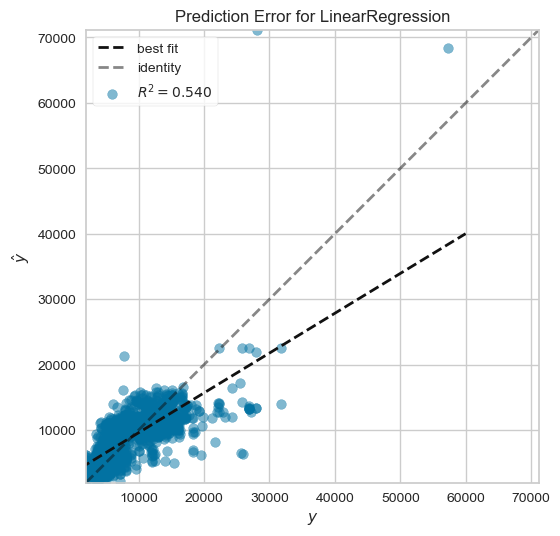

In [17]:
# Evaluate the model
pred_eval(lr_model)

we can see that the huge rmse error is because of those 2 outliers


In [18]:
# let's also check the coefficients
lr_model.coef_

array([ 2.06296931e+02,  7.47003362e-01,  3.59857489e+03, -6.90563577e+01,
       -7.92368819e+01,  2.58406306e+01, -8.37810532e-01, -1.85759950e+01,
       -5.10070485e-01,  7.49729742e+12, -1.01767149e+02, -9.47106684e+01,
        7.97902148e+01,  4.25780386e+02,  2.57696721e+15, -7.78588420e+13,
       -1.29823301e+14, -6.30334578e+13, -5.94617565e+13, -1.14828706e+14,
       -5.92925459e+13, -2.72178510e+15,  1.78272436e+03,  7.61058345e+02,
        4.90232854e+04, -6.74515433e+03, -9.57318071e+03, -1.08530225e+04,
       -8.55011652e+03, -4.35551657e+03])

### Elastic Net


In [7]:
# Instantiating the ElasticNetCV model

elastic_net_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                 eps=0.001,
                                 n_alphas=100,
                                 cv=10,
                                 max_iter=10000,
                                 n_jobs=-1)

In [8]:
# Fit the model
elastic_net_model.fit(X_train,y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000, n_jobs=-1)

In [9]:
# let's check the l1 ratio
elastic_net_model.l1_ratio_

1.0

our model is completely Lasso

In [10]:
# let's check the alpha value
elastic_net_model.alpha_

1182.7645232543775

mae is  2398.1747436052724
rmse is  3452.0107469285217
r2_score is  0.43555735581107113


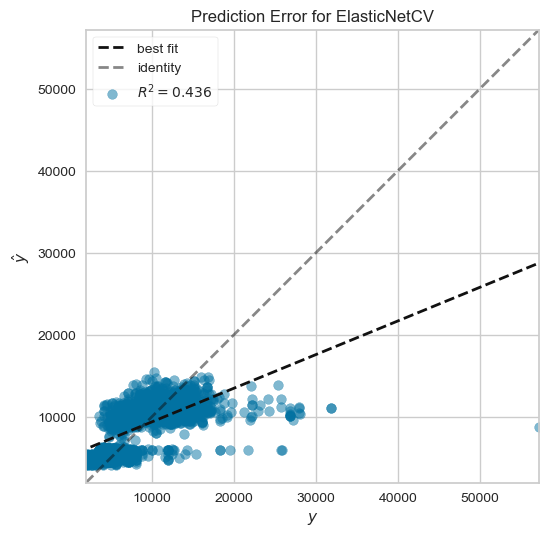

In [11]:
# evaluate the model
pred_eval(elastic_net_model)

In [12]:
# coefficients
elastic_net_model.coef_

array([   0.        ,    1.87350891,    0.        ,  -58.17205553,
         -0.        ,    0.        ,    0.        ,   -0.        ,
         -0.        ,   -0.        ,  -45.69308317, -169.13973672,
        -91.10668405,   -0.        ,   -0.        ,    0.        ,
         -0.        ,   -0.        ,    0.        ,    0.        ,
         -0.        ,   -0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,   -0.        ,   -0.        ,
          0.        ,    0.        ])

most of the coeffs are 0 since our model is completely lasso now 

linear models are not giving good results so let's move to Tree based models

### Decision Tree

In [14]:
# instantiate our model
dec_tree_model = DecisionTreeRegressor()

In [15]:
# fit the model
dec_tree_model.fit(X_train,y_train)

DecisionTreeRegressor()

mae is  722.9091405396974
rmse is  2226.3291179206653
r2_score is  0.7652236900771273


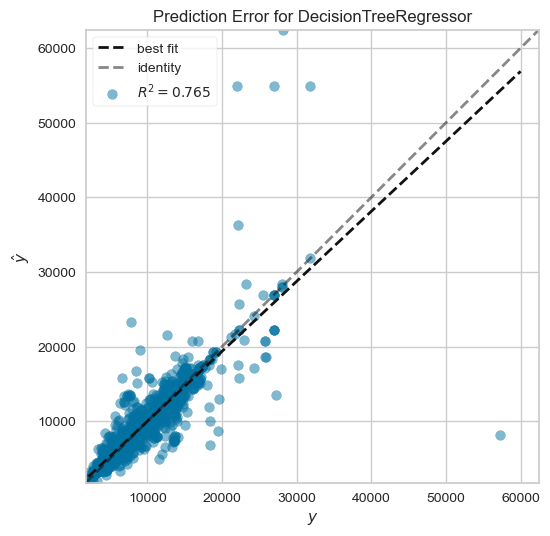

In [16]:
pred_eval(dec_tree_model)

In [17]:
dec_tree_model.feature_importances_

array([1.07160896e-01, 4.58551501e-01, 3.15831207e-02, 1.17237637e-01,
       6.66540579e-02, 2.13326946e-02, 2.23938525e-02, 2.02391208e-02,
       1.52499848e-02, 5.97398351e-03, 4.44554158e-02, 1.86752155e-02,
       6.86856999e-03, 3.11003315e-06, 2.52340162e-03, 3.06841409e-03,
       2.38757780e-03, 2.34199971e-03, 5.76197911e-04, 1.75115672e-03,
       6.20749767e-10, 2.36491393e-05, 0.00000000e+00, 0.00000000e+00,
       2.55629417e-02, 3.11176679e-04, 2.34129891e-02, 9.09410819e-06,
       1.65224084e-03, 0.00000000e+00])

### RandomForestRegressor

In [18]:
# first we'll see the baseline performance
rf_model = RandomForestRegressor()

In [19]:
rf_model.fit(X_train,y_train)

RandomForestRegressor()

mae is  638.53115995016
rmse is  1708.1765906192372
r2_score is  0.8617894894667757


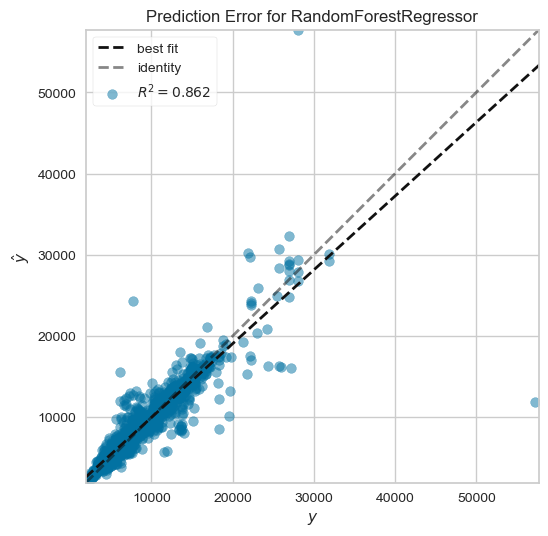

In [20]:
pred_eval(rf_model)

RandomForestRegressor is performing significantly better than all other models

so we'll try to improve it with hyperparameter tuning

### RandomForestRegressor with GridSearchCV

In [21]:
# make a dictionary of all the hyperparameters

rf_grid = {'n_estimators':[100,200,500],
           'max_depth':[None,5,10],
           'min_samples_split':[2,3,4],
           'min_samples_leaf':[1,2,3]}

In [22]:
# Instantiate the model with GridSearchCV
rf_cv = GridSearchCV(RandomForestRegressor(),
                     param_grid=rf_grid,
                     cv=5,
                     n_jobs=-1,
                     verbose=True)

In [24]:
# fitting the cross validated model 
rf_cv.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200, 500]},
             verbose=True)

In [25]:
# check the best hyperparameters
rf_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

mae is  646.7375948377585
rmse is  1728.6783725631078
r2_score is  0.8584519350552848


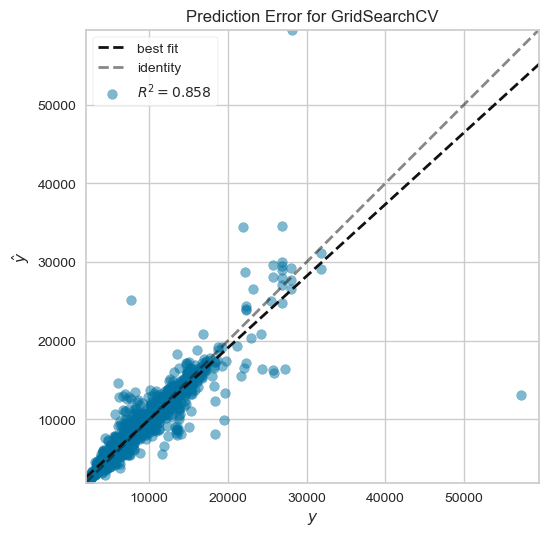

In [26]:
# evaluate
pred_eval(rf_cv)

Turns out that the baseline RandomForest performed slightly better than crossvalidated one

of course we can experiment and try to increase the number of hyperparameters in our gridsearch in hopes of achieving more better results

we can also experiment with the encoding of data while data cleaning to get different results

or we can collect more data 

#### Feature importance

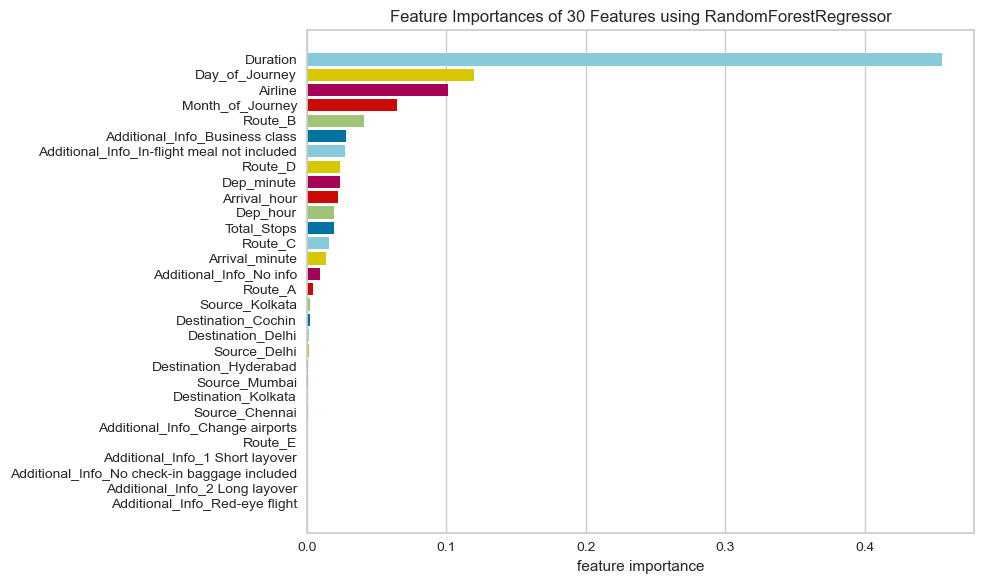

<AxesSubplot:title={'center':'Feature Importances of 30 Features using RandomForestRegressor'}, xlabel='feature importance'>

In [27]:
# visualizing the feature importance of RandomForest (baseline)
from yellowbrick.model_selection import FeatureImportances
plt.figure(figsize=(10,6),dpi=100)
viz = FeatureImportances(rf_model,relative=False)
#fit on train dataset
viz.fit(X_train, y_train)
#show plot and save at output path
viz.show()

In [29]:
# Saving the model
from joblib import dump,load
dump(rf_model,'saved_models/rf_model.joblib')

['saved_models/rf_model.joblib']